# Projeto Spark

### Cicero Tiago Carneiro Valentim

A ser realizado individualmente.

Entrega: 17 de junho de 2022


In [1]:
import pyspark

conf = pyspark.SparkConf()
conf.setAppName('Minha aplicação')
conf.setMaster('local[*]')

sc = pyspark.SparkContext(conf=conf)

In [2]:
sc

<SparkContext master=local[*] appName=Minha aplicação>

## Introdução

Neste projeto vamos construir um classificador Naive-Bayes para determinar o sentimento de um comentário. Vamos começar lendo o arquivo de reviews e gravando o resultado em formato pickle, mais amigável.

In [3]:
def parse_line(line):
    parts = line[1:-1].split('","')
    sentiment = int(parts[0])
    title = parts[1].replace('""', '"')
    body = parts[2].replace('""', '"')
    return (sentiment, title, body)

rdd = sc.textFile('train.csv').map(parse_line)
# rdd = sc.textFile('train.csv').map(parse_line).sample(False, 0.001)

In [4]:
rdd.count()

3600000

In [5]:
rdd.take(1)

[(2,
  'Stuning even for the non-gamer',
  'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^')]

Agora vamos gravar no formato pickle, para facilitar os trabalhos futuros. Após gravar o arquivo, não mais rode as células desta primeira etapa!

In [8]:
# !rm -rf reviews.pickle

In [9]:
rdd.saveAsPickleFile('reviews.pickle')

## Um classificador Naive-Bayes

Vamos ler o arquivo pickle gravado anteriormente:

In [10]:
rdd = sc.pickleFile('reviews.pickle')

In [11]:
rdd.count()

3600000

In [12]:
rdd.take(1)

[(1,
  'LOUSEY!!',
  "Mob HitsTHIS IS NOT KARAOKE .... THIS IS A VERY POOR VOCAL CD AND IS USLESS IN A CD/G PLAYER .... FUGETTABOUTIT .. I OPENED IT AND WAS NEVER SO DISSAPOINTED ... JUST SOME UNKNOWN BACALA TRYING TO MAKE FUN OF US I TINK. YA KNOW PIASON.. DA FISHY'S,DAY NEED TO EAT TOO.")]

Agora, complete as tarefas em sequencia para construir o classificador Naive-Bayes:

### Fase 1

#### Tarefa

Construa uma função que recebe um RDD no formato do RDD original e retorna um RDD no qual cada item é um par (palavra, contagem).

In [54]:
import string
import re

def sanitize(text: str):
    # https://www.w3schools.com/python/ref_string_maketrans.asp
    # https://datagy.io/python-remove-punctuation-from-string/
    # https://stackoverflow.com/a/1546244
    punctuation_pattern = re.compile(f'[{string.punctuation}]')
    mult_spaces_pattern = r'\s{2,}'
    text = re.sub(punctuation_pattern, ' ', text)
    text = re.sub(mult_spaces_pattern, ' ', text)
    return text.strip().lower()

test = "This!     is    a;very_well-formatted string-__"
sanitize(test) # 'This'

'this is a very well formatted string'

In [14]:
def count_words(rdd):
    text2words = lambda text: sanitize(text).strip().split()
    # 1. split title and body and joins the resulting list      
    # 2. convert each resulting word of the last step into a pair (word, 1)
    # 3. sum the resulting pairs when the words are equal
    return rdd \
        .flatMap(lambda line: text2words(line[1]) + text2words(line[2]) )\
        .map(lambda x: (x, 1)) \
        .reduceByKey(lambda x, y: x + y) \
        .cache()

# count_words(rdd).take(1)

#### Tarefa

Construa uma função que recebe o RDD (palavra, contagem) construido anteriormente e retorna um RDD no qual cada item é um par (palavra, $\log_{10}\left(c \, / \, T\right)$), onde $c$ é a contagem daquela palavra e $T$ é a soma das contagens de palavra.

In [15]:
import numpy as np

def count_words_rel(rdd_count):
    total = rdd_count.map( lambda tup: tup[1] ).sum()
    return rdd_count.map( lambda line: (line[0], np.log10(line[1]/total)) )


#### Tarefa

Separe o RDD original em dois RDDs: o dos reviews positivos e o dos negativos. Em seguida, use as funções anteriores para construir RDDs que contem os pares (palavra, $\log_{10}\left(c \, / \, T\right)$)

In [16]:
rdd_neg = rdd.filter(lambda line: line[0] == 1)
rdd_pos = rdd.filter(lambda line: line[0] == 2)

In [18]:
rdd_neg_abs = count_words(rdd_neg)
rdd_pos_abs = count_words(rdd_pos)

In [19]:
rdd_neg_rel = count_words_rel(rdd_neg_abs)
rdd_pos_rel = count_words_rel(rdd_pos_abs)

### Tarefa

Use o `.fullOuterJoin()` dos RDDs para construir um RDD unificado, no qual cada item é da forma (palavra, log_prob_positivo, log_prob_negativo). "Baixe" esse resultado final usando `.collect()`.

In [28]:
# (word, (neg, pos))
unified_rdd = rdd_neg_rel.fullOuterJoin(rdd_pos_rel)

In [29]:
collection = dict(unified_rdd.collect())

In [22]:
# collection = unified_rdd

In [348]:
# unified_rdd.filter(lambda probs: probs[0] == 'out' ).first()

#### Tarefa

Para uma dada string, determine se ela é um review positivo ou negativo usando os RDDs acima. Lembre-se de como funciona o classificador Naive-Bayes: http://stanford.edu/~jurafsky/slp3/slides/7_NB.pdf, consulte tambem suas notas de aula de Ciência dos Dados!

In [30]:
class BaseClassifier:
    def __init__(self, collection: dict):
        self.collection = collection
    
    @staticmethod
    def prepro(text: str) -> list:
        return sanitize(text).split()

    def predict(self, text: str) -> int:
        pass
    

class NBClassifier(BaseClassifier):
    def predict(self, text: str) -> int:
        """Does not implement Laplace Smoothing."""
        # probabilidade de ser positiva
        words = NBClassifier.prepro(text)
        
        neg_accumulator = 0
        pos_accumulator = 0
        
        for word in words:
            probs = self.collection.get(word, (None, None))
            
            if probs is None: continue # if the word is unknown, ignore
            
            neg_prob, pos_prob = probs
        
            if neg_prob is not None:
                neg_accumulator += neg_prob

            if pos_prob is not None:
                pos_accumulator += pos_prob
                
        # return 1 + pos_accumulator > neg_accumulator
        if pos_accumulator > neg_accumulator:
            return 2
        return 1

In [33]:
test_string = "This is a very Very!!! neat string"

print(NBClassifier.prepro(test_string))

nb_classifier = NBClassifier(collection)

nb_classifier.predict(test_string)

['this', 'is', 'a', 'very', 'very', 'neat', 'string']


2

### Fase 2

Agora que temos um classificador Naive-Bayes, vamos explorá-lo um pouco:

### Tarefa

Quais são as 100 palavras que mais indicam negatividade, ou seja, onde a diferença entre a probabilidade da palavra no conjunto dos comentários negativos e positivos é máxima? E quais as 100 palavras de maior positividade? Mostre os resultados na forma de *word clouds*.

In [35]:
# acho que não vou usar o classificador pra isso. 
# Tudo indica que os métodos do spark são mais eficientes.
# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.sortBy.html

def is_valid(tup):
    # both negative and positive probability must be defined
    word, (neg, pos) = tup
    return neg is not None and pos is not None

def positivity(tup):
    word, (neg, pos) = tup
    # if neg is None: neg = 0
    # if pos is None: pos = 0
    return pos - neg

negative_words = unified_rdd.filter(is_valid).sortBy(positivity, ascending=True).map(lambda tup: tup[0]).take(100)
positive_words = unified_rdd.filter(is_valid).sortBy(positivity, ascending=False).map(lambda tup: tup[0]).take(100)

In [39]:
print(negative_words[45:55])
print(positive_words[45:55])

['porqueria', 'warrantly', 'decepcionante', 'mortier', 'zzzzzzzzzzzzzzzzzz', 'knowledgebase', 'unerotic', 'returnable', 'crapfest', 'snoozefest']
['rosenfelt', 'digno', 'outsanding', 'skatalites', 'kadison', 'preciosa', 'unintimidating', 'llorar', 'grrrrreat', 'jiro']


In [40]:
!pip install wordcloud

In [41]:
import wordcloud as wc
# http://amueller.github.io/word_cloud/auto_examples/simple.html
wc_config = dict(
    width=1200,
    height=400,
    min_font_size=12,
    max_font_size=48, # a maior palavra é no máximo 4 vezes maior que a menor
)

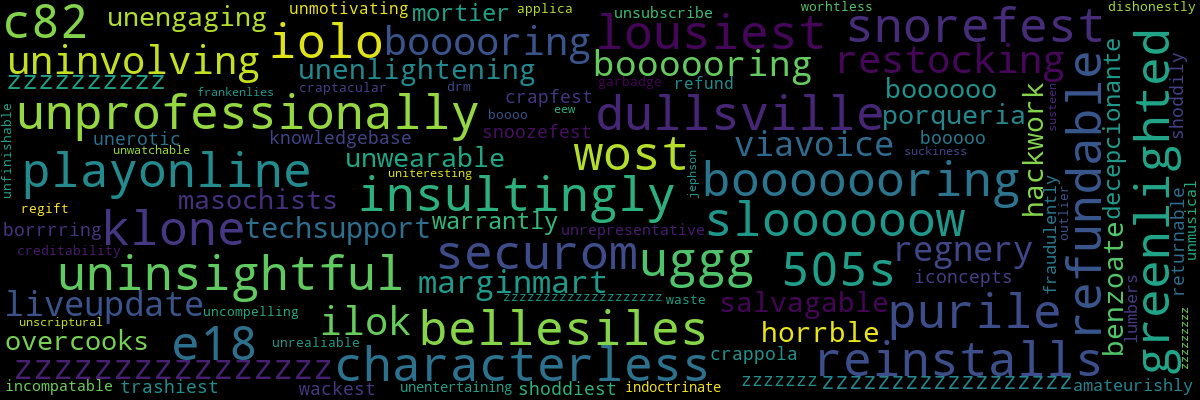

In [42]:
# top 100 palavras com maior negatividade
neg_img = wc.WordCloud(**wc_config).generate(' '.join(negative_words))
neg_img.to_image()

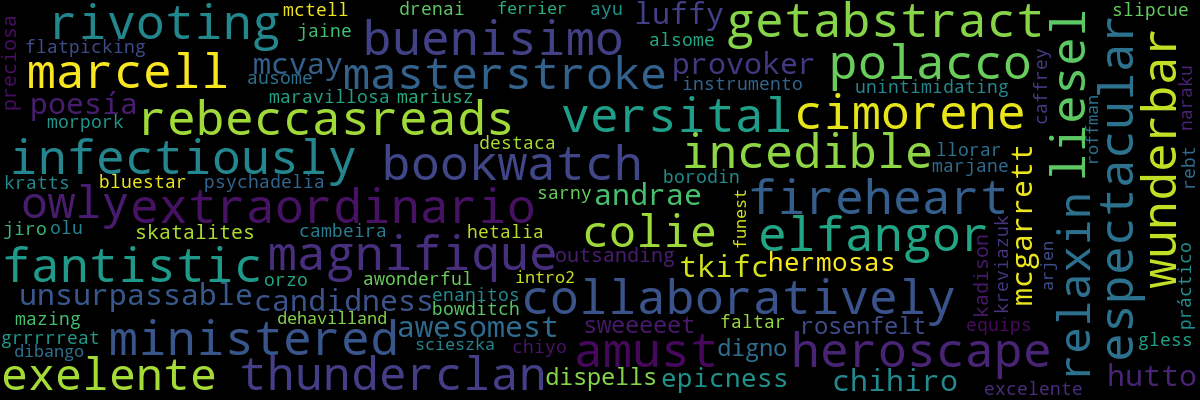

In [43]:
# top 100 palavras com maior positividade
pos_img = wc.WordCloud(**wc_config).generate(' '.join(positive_words))
pos_img.to_image()

### Tarefa desafio!

Qual o desempenho do classificador (acurácia)? Para medir sua acurácia:

- Separe os reviews em dois conjuntos: treinamente e teste
- Repita o "treinamento" do classificador com o conjunto de treinamento
- Para cada review do conjunto de teste, determine se é positiva ou negativa de acordo com o classificador
- Determine a acurácia

Esta não é uma tarefa trivial. Não basta fazer um `for` para determinar a classe de cada review de teste: isso demoraria uma eternidade. Você tem que usar variáveis "broadcast" do Spark para enviar uma cópia da tabela de frequencias para cada *core* do executor.

In [44]:
# https://stackoverflow.com/a/32857707
rdd_train, rdd_test = rdd.randomSplit(weights=[80, 20], seed=42)

In [47]:
def train(rdd):
    """Receives and rdd and returns a collection of 
    words and probabilities according to the model { [word]: (prob_neg, prob_pos) }"""
    # split in positive and negative reviews
    rdd_negative = rdd.filter(lambda line: line[0] == 1)
    rdd_positive = rdd.filter(lambda line: line[0] == 2)

    # absolute count of ocurrencies
    rdd_neg_abs = count_words(rdd_negative)
    rdd_pos_abs = count_words(rdd_positive)

    # relative count of ocurrencies
    rdd_pos_rel   = count_words_rel(rdd_pos_abs)
    rdd_neg_rel   = count_words_rel(rdd_neg_abs)
    
    unified = rdd_neg_rel.fullOuterJoin(rdd_pos_rel) # ( word, (neg_probability, pos_probability) )
    return dict(unified.collect())

In [48]:
training_collection = train(rdd_train)

In [49]:
# total testing reviews
total_testing_reviews = rdd_test.count()
print(f"Total testing reviews: {total_testing_reviews}")

test_classifier = NBClassifier(training_collection)

Total testing reviews: 720351


In [51]:
# rdd_test = (clasf, title, body )
def mapper(tup):
    clasf, title, body = tup
    prediction = test_classifier.predict( f'{title} {body}' )

    return (clasf, prediction)
    
rdd_predicted = rdd_test.map(mapper)
correct_predictions = rdd_predicted.filter(lambda tup: tup[0] == tup[1]).count()
accuracy = correct_predictions/total_testing_reviews

print(f"Total correct predictions: {correct_predictions} out of {total_testing_reviews}")
print(f"Accuracy: {accuracy} or {accuracy*100} %")

Total correct predictions: 588618 out of 720351
Accuracy: 0.8171266507577556 or 81.71266507577556 %


### Tarefa desafio!

Implemente Laplace smoothing

In [53]:
class NBClassifierLS(BaseClassifier):
    """Reimplementation of Naive-Bayes Classifier with Laplace smoothing"""
    
    def predict(self, text:str) -> int:
        """Implements Laplace Smoothing."""
        # https://towardsdatascience.com/laplace-smoothing-in-naïve-bayes-algorithm-9c237a8bdece
        pass

## Rubrica de avaliação

- I: groselha, falha crítica, ou não entregou nada
- D: Fez uma tentativa honesta de fazer todos os itens da fase 1, mas tem erros
- C: Fase 1 completa
- B: Fase 2, faltando apenas um desafio
- A: Fase 2 completa